In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#
# Note: 1 year ago from today was 9-20-2017 and there is no data in Measurement table from that date until now
# so I will try to query 1 year worth of data from the last date in the Measurement table

In [11]:
# Find latest date shown in the Measurement table

# This will store latest_date in Measurement table
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Next need to unpack to then store as a string called lat_dat
lat_dat = latest_date[0]
lat_dat

'2017-08-23'

In [12]:
#Split string into list elements to then use later as int arguments passed in the dt.date() function

split_lat_dat = lat_dat.split("-")
year_val = int(split_lat_dat[0])
month_val = int(split_lat_dat[1])
day_val = int(split_lat_dat[2])

In [13]:
# determine date 1 year ago from latest date shown in the Measurement table
previous_year_date = dt.date(year_val, month_val, day_val) - dt.timedelta(days=365)
print(previous_year_date)

2016-08-23


In [14]:
# Perform a query to retrieve the date and precipitation amounts

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > previous_year_date).\
    order_by(Measurement.date).all()

In [15]:
# results is a list of tuples from query above

# set labels for dataframe. first column will be date and second column will be precipitation
labels = ['date', 'precipitation']

# use from_records in pandas to create dataframe
df = pd.DataFrame.from_records(results, columns=labels)

In [16]:
#set the index to the date column
df.set_index('date')

df.head(10)

,date,precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
5,2016-08-24,2.15
6,2016-08-24,1.45
7,2016-08-25,0.08
8,2016-08-25,0.08
9,2016-08-25,0.00


<IPython.core.display.Javascript object>


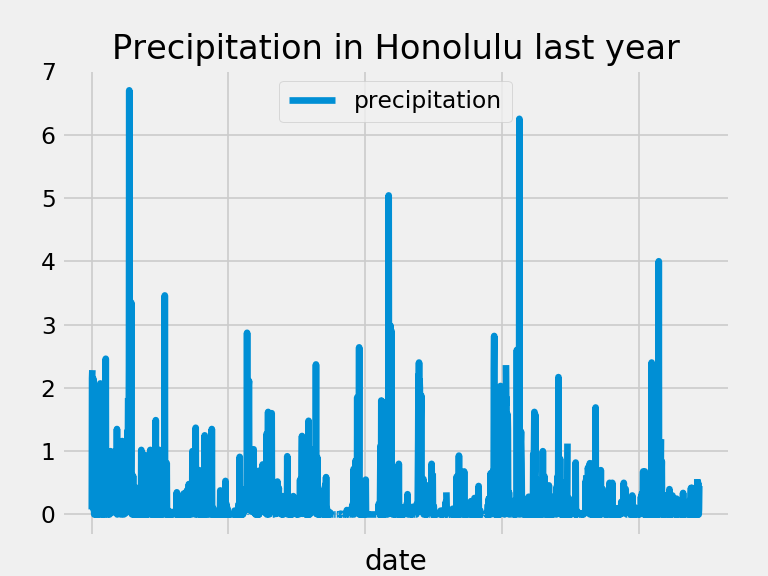

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data with x-axis as date and y-axis as precipitation
df.plot(x='date', y='precipitation', title='Precipitation in Honolulu last year')

In [18]:
# Plot below was in the starter code

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# How many stations are available in this dataset?
stations_number_results = session.query(Station.id).count()
stations_number_results

9

In [21]:
# What are the most active stations?
# List the stations and the counts in descending order.

# Look for station column in Measurement table and do a count of the corresponding tobs column in Measurement table
stations_obs_results = [Measurement.station, 
       func.count(Measurement.tobs)]

# unpack stations_obs_results, group by station name and order by count of observations in descending order
most_active_stations_query = session.query(*stations_obs_results).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
# Output most active stations in descending order
most_active_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Station USC00519281 has the highest number of observations

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Get the lowest temperature using min function, highest temperature using max function, and average temperature using avg function
temp_obs_results_most_active = [func.min(Measurement.tobs),
                               func.max(Measurement.tobs),
                               func.avg(Measurement.tobs)]

# unpack temp_obs_results_most_active and filter by most active station which we determined earlier was USC00519281
temp_obs_most_active_query = session.query(*temp_obs_results_most_active).\
    filter (Measurement.station == "USC00519281").all()

# output lowest temp, highest temp, and average temp (in that order) for most active station USC00519281
temp_obs_most_active_query

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Verify value of previous_year_date
previous_year_date

datetime.date(2016, 8, 23)

<IPython.core.display.Javascript object>


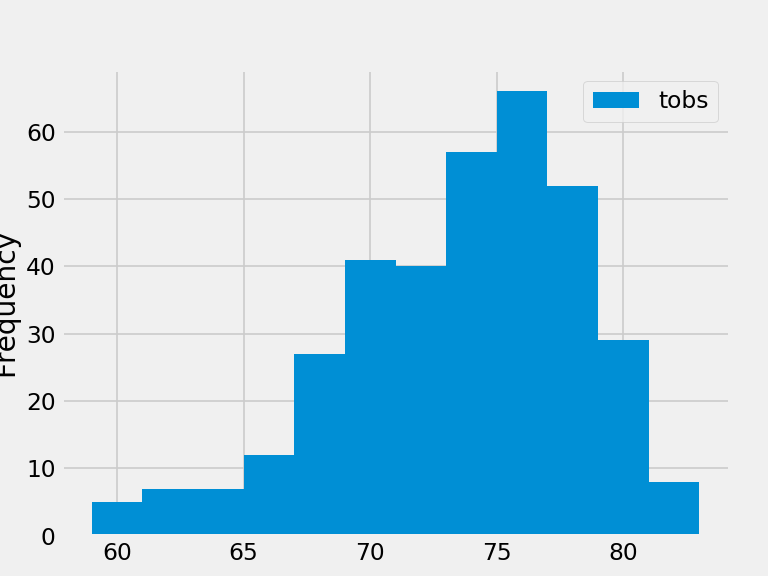

In [24]:
# Choose the station with the highest number of temperature observations.
# Station with highest number of temperature observations as determined above was USC00519281

# Query the last 12 months of temperature observation data for this station 
most_active_station_tobs_results = session.query(Measurement.tobs).\
    filter(Measurement.date > previous_year_date).\
    filter(Measurement.station == "USC00519281").all()

# results is a list of tuples from query above

# set labels for dataframe. only column we care about for this histogram is tobs
labels = ['tobs']

# use from_records in pandas to create dataframe
most_active_station_tobs_last12_df = pd.DataFrame.from_records(most_active_station_tobs_results, columns=labels)

#and plot the results as a histogram with bins=12
most_active_station_tobs_last12_df.plot.hist(bins=12)

In [25]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# at the start of this notebook, lat_dat was the string value of the last date that had an observation which was '2017-08-23'
# we also set previous_year_date to '2016-08-23'
print(lat_dat)
print(previous_year_date)

2017-08-23
2016-08-23


In [27]:
#use `calc_temps` function to calculate the tmin, tavg and tmax
# for trip using previous year's data for those dates

temp_values_calculated = calc_temps(previous_year_date, lat_dat)
temp_values_calculated

[(58.0, 74.59058295964125, 87.0)]

In [28]:
# temp_values_calculated is a list with one tuple
# so unpack to get to the tuple and call that temp_values_calc_tup

temp_values_calc_tup = temp_values_calculated[0]

# now store tmin as first element in temp_values_calc_tup
tmin_value = temp_values_calc_tup[0]
print(tmin_value)
#store tavg as second element in temp_values_calc_tup
tavg_value = temp_values_calc_tup[1]
print(tavg_value)
# store tmax as third element in temp_values_calc_tup
tmax_value = temp_values_calc_tup[2]
print(tmax_value)

58.0
74.59058295964125
87.0


In [29]:
# peak_to_peak value will be tmax_value - tmin_value
peak_to_peak_value = tmax_value - tmin_value
print(peak_to_peak_value)

29.0


In [30]:
# create a dataframe to then plot using pandas

temperature_df = pd.DataFrame({'tmin':[tmin_value], 'tavg':[tavg_value], 'tmax':[tmax_value]})
temperature_df

,tmin,tavg,tmax
0,58.0,74.590583,87.0


<IPython.core.display.Javascript object>


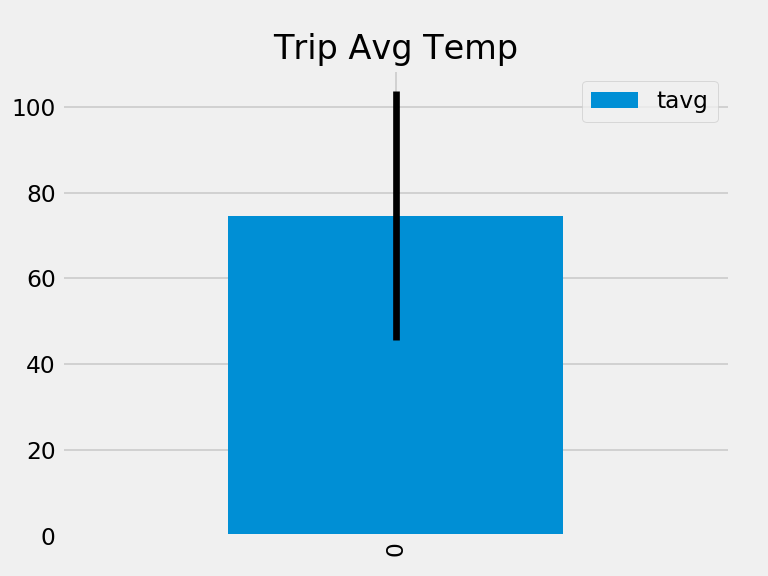

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temperature_df.plot(kind='bar', y='tavg', title='Trip Avg Temp', yerr=peak_to_peak_value)


In [32]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Columns will be station, name of station, latitude, longitude, elevation, and sum of precipitation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

# join Station table and Measurement table on station columns which is in both tables
# filter only data greater than previous_year_date which is 2016-08-23
# group by station column
# order by sum of precipitation amount in descending order
same_station = session.query(*sel).filter(Station.station == Measurement.station).\
    filter(Measurement.date > previous_year_date).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()


same_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.11000000000004),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  68.24000000000002),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  48.36000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  37.99),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.19),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.089999999999986),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


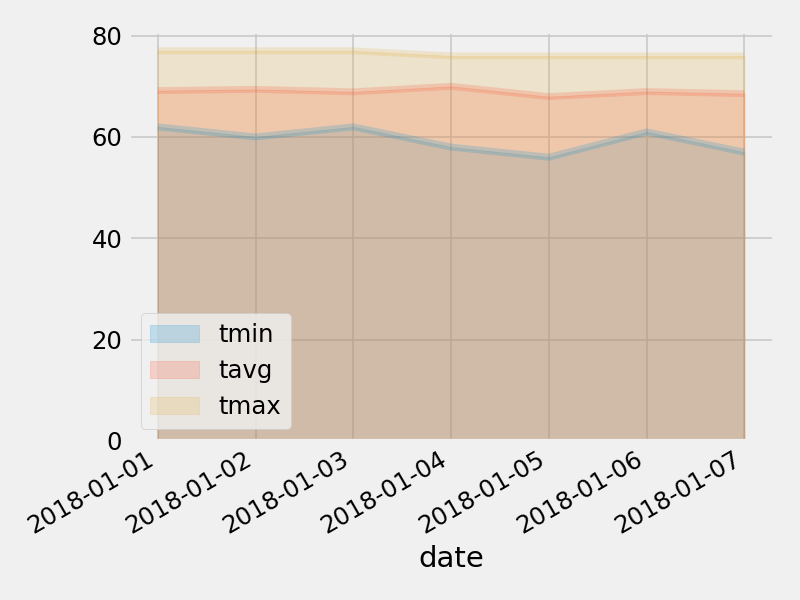

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
